In [38]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

%matplotlib inline

In [3]:
X_raw = pd.read_csv('./../../../data_source/to_analysis/no_filter_concat.csv', index_col=0)
y_raw = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)

In [5]:
X_std = StandardScaler().fit_transform(X_raw)
y = np.squeeze(y_raw.values)

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
n_samples = np.size(y)
outliers_fraction = 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [9]:
anomaly_algorithms = [
    ('Robust covariance', EllipticEnvelope(
        contamination=outliers_fraction
    )),
    ('One-Class SVM', svm.OneClassSVM(
        nu=outliers_fraction, kernel="rbf", gamma=0.1
    )),
    ('Isolation Forest', IsolationForest(
        behaviour='new',
        contamination=outliers_fraction,
        random_state=42
    )),
    ('Local Outlier Factor', LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction
    ))
]

Text(0, 0.5, 'Z-scored Feature')

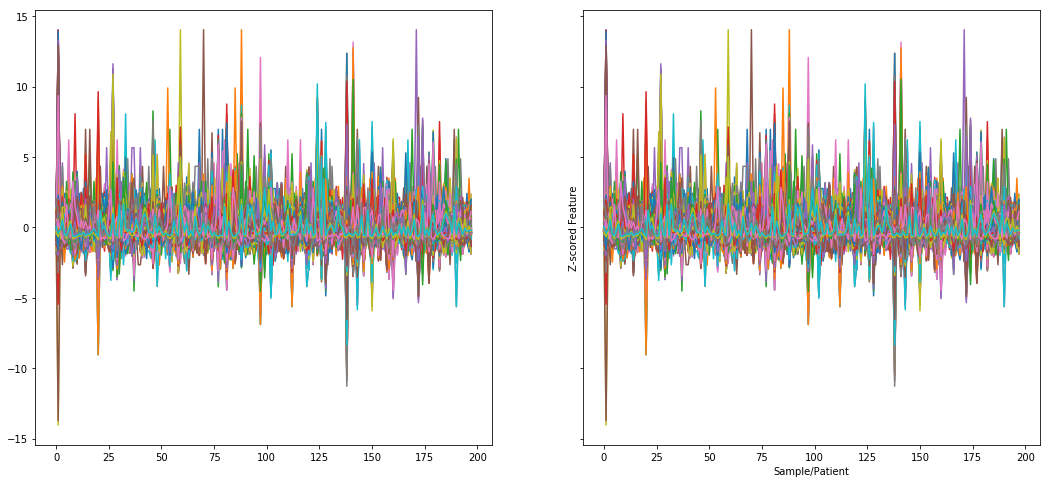

In [48]:
nrows, ncols = np.shape(X_std)
fig, axes = plt.subplots(ncols=2, figsize=(18, 8), sharex=True, sharey=True)
for col_num in range(ncols):
    #axes[0].scatter(range(nrows), X_std[:, col_num], s=9)
    #axes[1].scatter(range(nrows), X_std[:, col_num], c=y==1, s=9)
    axes[0].plot(range(nrows), X_std[:, col_num])
    axes[1].plot(range(nrows), X_std[:, col_num])
plt.xlabel('Sample/Patient')
plt.ylabel('Z-scored Feature')